In [23]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Dataset.

In [112]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# We'll drop the 'id' column as it's just an identifier
df.drop('id', axis=1, inplace=True)
df.drop('Project', axis=1, inplace=True)

In [96]:
df.head()

TeamExp  ManagerExp  YearEnd  Length  Effort  Transactions  Entities  \
0        1           4       85      12    5152           253        52   
1        0           0       86       4    5635           197       124   
2        4           4       85       1     805            40        60   
3        0           0       86       5    3829           200       119   
4        0           0       86       4    2149           140        94   

   PointsNonAdjust  Adjustment  PointsAjust  Language  
0              305          34          302         1  
1              321          33          315         1  
2              100          18           83         1  
3              319          30          303         1  
4              234          24          208         1

# Data Visualization

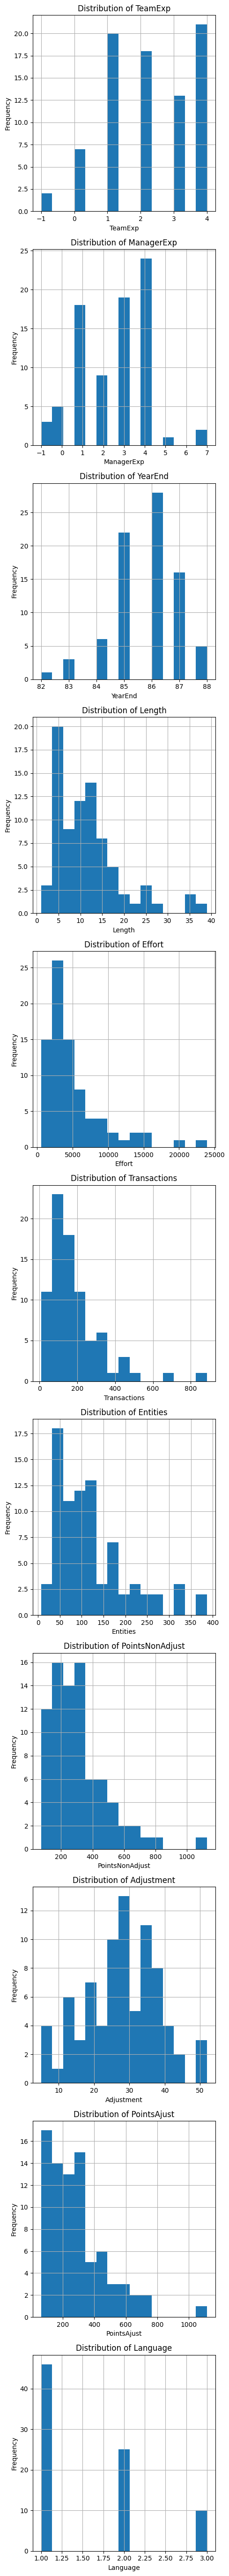

In [97]:
# Plotting
num_columns = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(len(num_columns), 1, figsize=(5, 5 * len(num_columns)))

for i, col in enumerate(num_columns):
    df[col].hist(ax=axes[i], bins=15)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

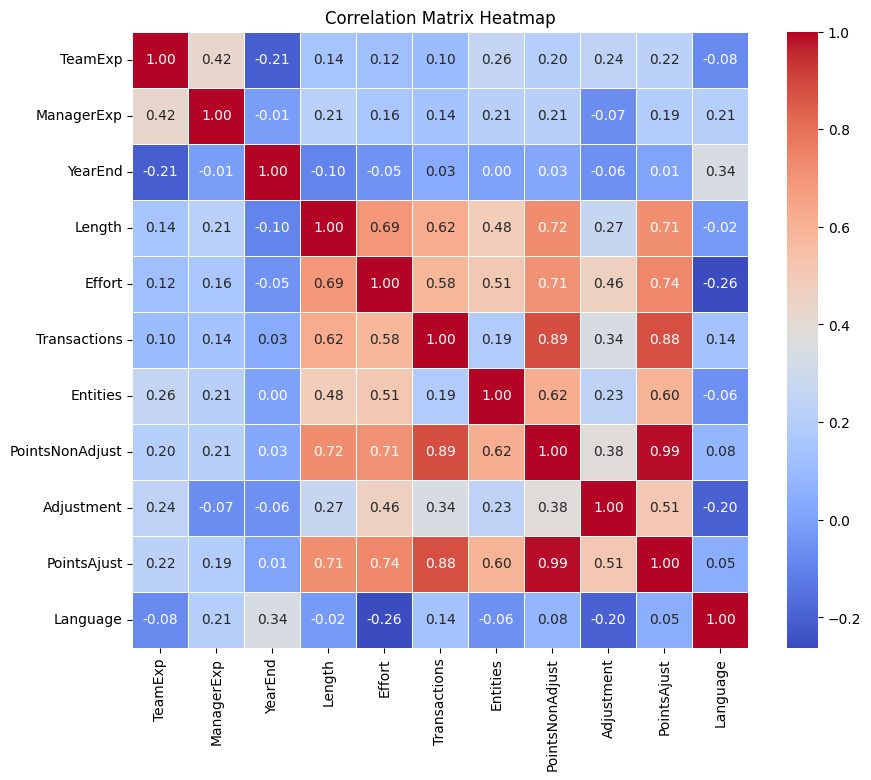

In [98]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [113]:
# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(df.drop('Effort', axis=1))

# Convert features and target to tensors
features_tensor = torch.tensor(features, dtype=torch.float)
target_tensor = torch.tensor(df['Effort'].values, dtype=torch.float).unsqueeze(1)

# Creating a Graph
## This graph represents as a input to the Graph Neural Network

In [118]:
# Constructing a k-NN graph
# For demonstration, we'll use a simple threshold for edge creation based on Euclidean distance
# In a more advanced scenario, you would use an actual k-NN implementation
threshold = 3.0  # This threshold would need to be adjusted based on domain knowledge or experimentation
graph = nx.Graph()
num_nodes = len(df)

for i in range(num_nodes):
    graph.add_node(i)

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Calculate Euclidean distance between two nodes
        distance = torch.norm(features_tensor[i] - features_tensor[j])
        if distance < threshold:
            graph.add_edge(i, j)

# Convert to PyTorch Geometric data format
data = from_networkx(graph)
data.x = features_tensor
data.y = target_tensor

# Create masks for splitting the data
node_indices = list(range(data.num_nodes))
train_indices, test_indices = train_test_split(node_indices, test_size=0.2, random_state=42)

# Create train_mask and test_mask
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
test_mask[test_indices] = True

# Add masks to data
data.train_mask = train_mask
data.test_mask = test_mask

## Graph visualization through networkx module.

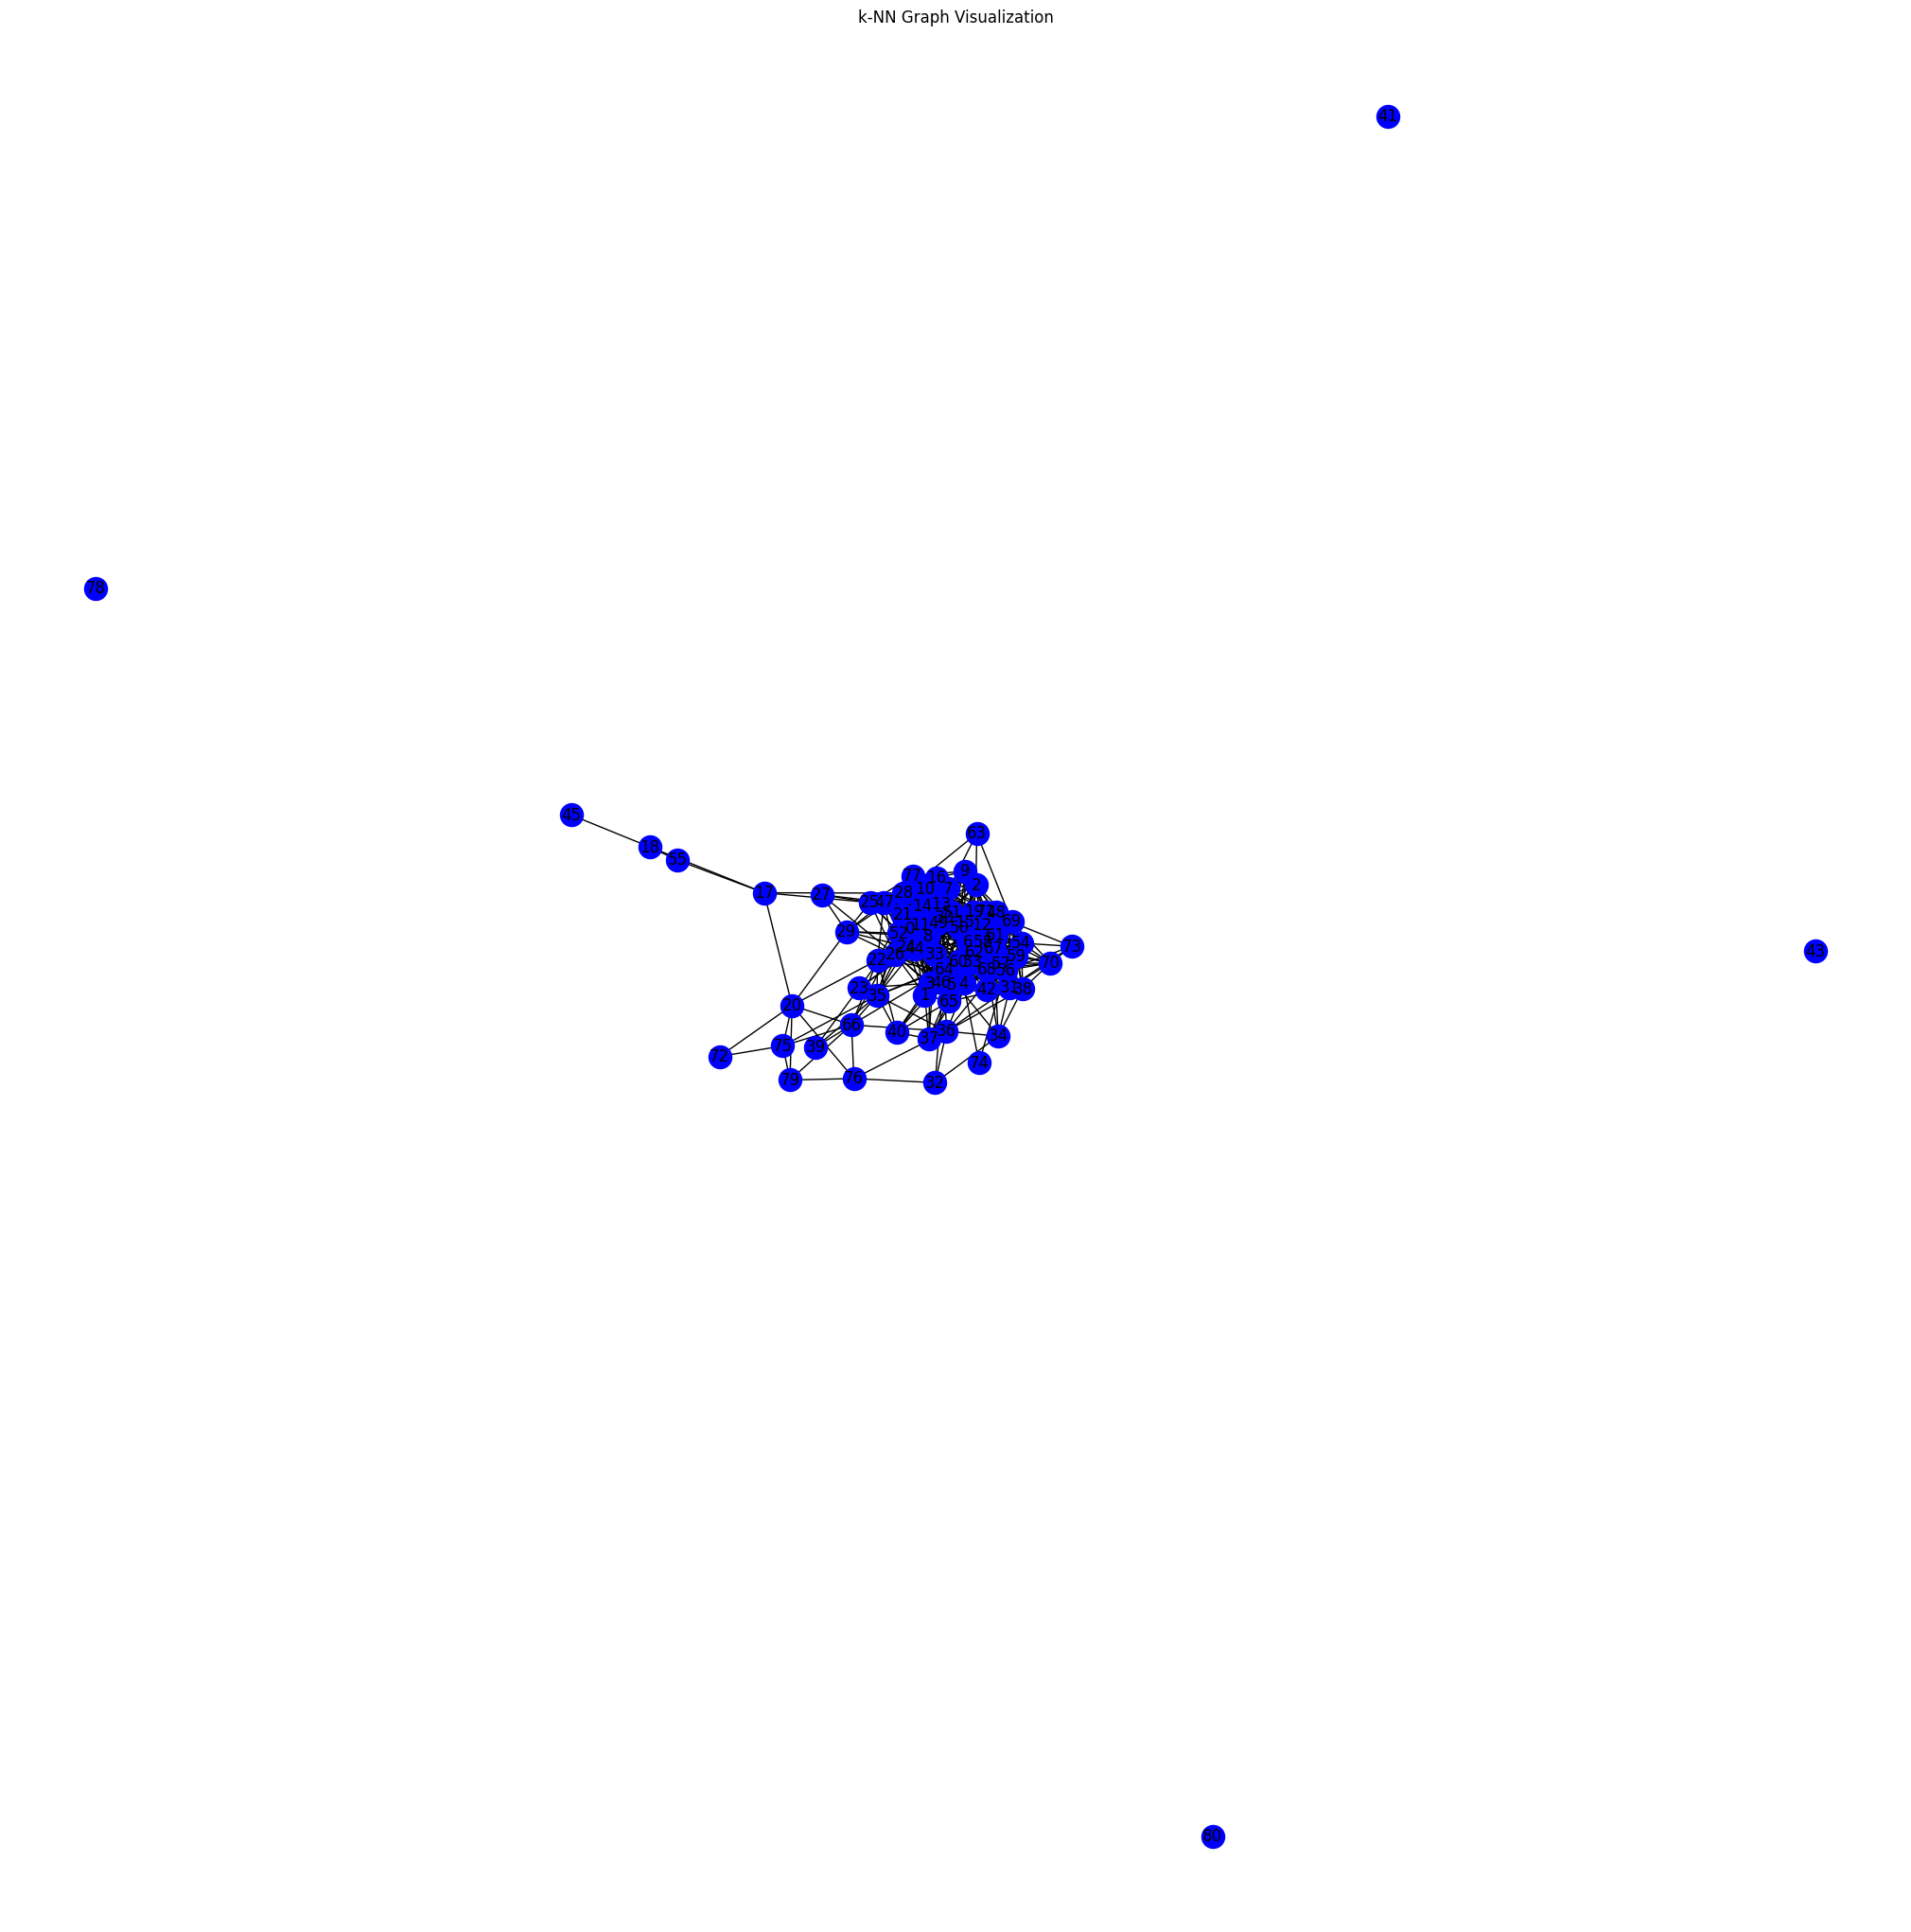

In [119]:
# Visualization part
plt.figure(figsize=(20,20))
pos = nx.spring_layout(graph)  # Use spring layout algorithm to position nodes
nx.draw(graph, node_color="blue", with_labels=True)
plt.title("k-NN Graph Visualization")
plt.show()

# Graph Convolutional Neural Network model.

In [103]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        # First graph convolution
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.5, train=self.training)

        # Second graph convolution
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Output layer
        x = self.out(x)
        return x


In [104]:
# Initialize the GCN model
model = GCN(num_features=features_tensor.size(1), hidden_channels=16)

# We will also need to define the loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training loop and Evaluation metrics

In [120]:
# Parameters
num_epochs = 100
train_losses = []
test_errors = []

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[data.train_mask]
    loss = loss_fn(out, data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def test():
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)
        pred = pred[data.test_mask]
        error = (pred - data.y[data.test_mask]).abs().mean().item()  # MAE
    return error

In [121]:
# Train model
for epoch in range(num_epochs):
    train_loss = train()
    test_error = test()
    train_losses.append(train_loss)
    test_errors.append(test_error)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Test MAE {test_error:.4f}')

Epoch 1: Train Loss 272703040.0000, Test MAE 3905.4453
Epoch 2: Train Loss 215145536.0000, Test MAE 3681.2246
Epoch 3: Train Loss 111629208.0000, Test MAE 3437.0244
Epoch 4: Train Loss 138409728.0000, Test MAE 3178.4207
Epoch 5: Train Loss 141187984.0000, Test MAE 2928.5962
Epoch 6: Train Loss 149762880.0000, Test MAE 2671.8645
Epoch 7: Train Loss 166772864.0000, Test MAE 2410.9556
Epoch 8: Train Loss 90383920.0000, Test MAE 2158.9751
Epoch 9: Train Loss 95633536.0000, Test MAE 1916.8213
Epoch 10: Train Loss 64188688.0000, Test MAE 1729.7998
Epoch 11: Train Loss 48347140.0000, Test MAE 1621.1810
Epoch 12: Train Loss 68628304.0000, Test MAE 1523.5968
Epoch 13: Train Loss 16618637.0000, Test MAE 1460.1501
Epoch 14: Train Loss 44181152.0000, Test MAE 1411.6345
Epoch 15: Train Loss 30615392.0000, Test MAE 1398.8756
Epoch 16: Train Loss 22213280.0000, Test MAE 1449.6007
Epoch 17: Train Loss 18072450.0000, Test MAE 1500.0535
Epoch 18: Train Loss 15799673.0000, Test MAE 1544.9255
Epoch 19: Tr

In [122]:
test_error = test()
print(f'Test MAE: {test_error:.4f}')

Test MAE: 1668.3723


# Plotting the Results

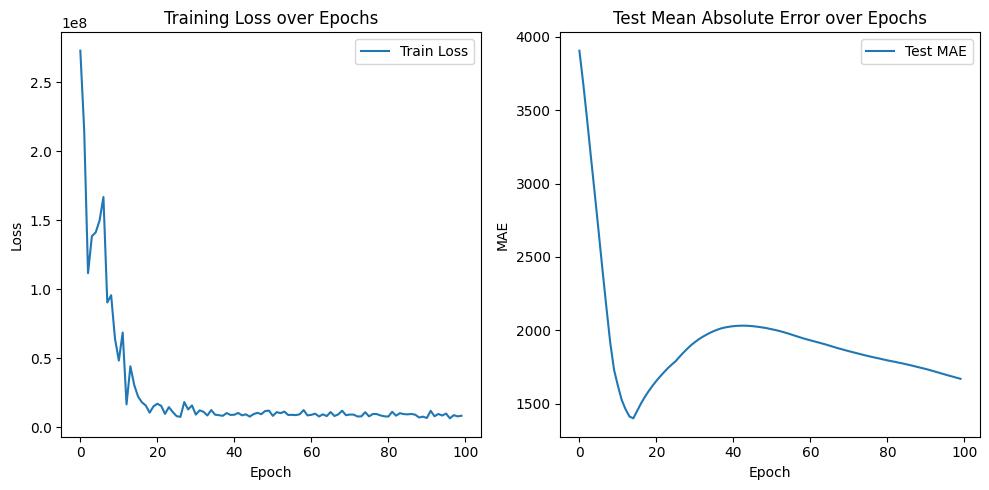

In [123]:
# Plotting training and testing results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_errors, label='Test MAE')
plt.title('Test Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


# Predicting with new data.
## Before passing it to the model it will first should be converted to Graph and then passed for predictions.

In [109]:
# Example training data columns (excluding the target 'Effort')
# Replace this list with the actual column names used in your training data
training_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Transactions', 'Entities', 'PointsNonAdjust', 'Adjustment', 'PointsAjust', 'Language']

# Example new data as a dictionary (replace with actual new data and ensure all columns are present)
new_data_example = {
    'TeamExp': 4,
    'ManagerExp': 4,
    'YearEnd': 86,
    'Length': 12,
    'Transactions': 318,   # Example feature values
    'Entities': 269,       # Example feature values
    'PointsNonAdjust': 587, # Example feature values
    'Adjustment': 34,     # Example feature values
    'PointsAjust': 581,   # Example feature values
    'Language': 2
}

# Convert the new data to a DataFrame and explicitly order the columns to match the training data
new_data_df = pd.DataFrame([new_data_example], columns=training_columns)

# Normalize the new data using the same scaler that was used for the training data
normalized_new_data = scaler.transform(new_data_df)

# Continue with the creation of the PyTorch Geometric Data object and prediction as before


In [110]:
# Convert the normalized features to a tensor
new_features_tensor = torch.tensor(normalized_new_data, dtype=torch.float)

# If you have no edge information, you would create an edge_index with no edges
new_edge_index = torch.tensor([], dtype=torch.long).view(2, -1)

# Create the new data object
new_data = Data(x=new_features_tensor, edge_index=new_edge_index)


In [124]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    new_pred = model(new_data.x, new_data.edge_index)
    print(f"Predicted Effort: {new_pred.squeeze().item()}")


Predicted Effort: 10637.33984375
